In [1]:
import pickle

# Open the pickle file in binary read mode ('rb')
with open('my_dict.pkl', 'rb') as file:
    batch = pickle.load(file)

# Now 'data' contains the Python object that was saved
print(batch.keys())

dict_keys(['batch_idx', 'bboxes', 'cls', 'im_file', 'img', 'ori_shape', 'resized_shape'])


In [2]:
# Open the pickle file in binary read mode ('rb')
with open('t_list.pkl', 'rb') as file:
    t_list = pickle.load(file)

# Now 'data' contains the Python object that was saved
print(len(t_list))

2


we have a tal based mask in both teacher and student's output

In [4]:
import cv2
import torch
import numpy as np

# Assuming you have a tensor with 8400 elements (boolean values)
tensor_8400 = t_list[0][2][-1]  # Your tensor with 8400 boolean values

# Reshape to three different sizes
tensor_80x80 = tensor_8400[:6400].reshape(80, 80)
tensor_40x40 = tensor_8400[6400:8000].reshape(40, 40)
tensor_20x20 = tensor_8400[8000:].reshape(20, 20)

# Convert boolean tensors to uint8 for OpenCV
def bool_to_image(bool_tensor):
    img_np = bool_tensor.cpu().numpy().astype(np.uint8) * 255
    return img_np

# Convert all tensors
img_80x80 = bool_to_image(tensor_80x80)
img_40x40 = bool_to_image(tensor_40x40)
img_20x20 = bool_to_image(tensor_20x20)

# Resize smaller images
img_40x40_resized = cv2.resize(img_40x40, (160, 160), interpolation=cv2.INTER_NEAREST)
img_20x20_resized = cv2.resize(img_20x20, (160, 160), interpolation=cv2.INTER_NEAREST)

# Calculate canvas dimensions
padding = 40
total_width = 80 + 160 + 160 + 4 * padding  # 3 images + 4 paddings
canvas_height = 200

# Create canvas
canvas = np.ones((canvas_height, total_width), dtype=np.uint8) * 255

# Calculate positions
x_positions = [
    padding,  # 80x80 start
    padding + 80 + padding,  # 40x40 start
    padding + 80 + padding + 160 + padding  # 20x20 start
]

# Place images on canvas
canvas[10:90, x_positions[0]:x_positions[0]+80] = img_80x80
canvas[20:180, x_positions[1]:x_positions[1]+160] = img_40x40_resized
canvas[20:180, x_positions[2]:x_positions[2]+160] = img_20x20_resized

# Add labels
cv2.putText(canvas, "80x80", (x_positions[0], 100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 0, 1)
cv2.putText(canvas, "40x40", (x_positions[1], 190), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 0, 1)
cv2.putText(canvas, "20x20", (x_positions[2], 190), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 0, 1)

# Add statistics
true_count_80x80 = tensor_80x80.sum().item()
true_count_40x40 = tensor_40x40.sum().item()
true_count_20x20 = tensor_20x20.sum().item()

stats_80x80 = f"True: {true_count_80x80}/6400"
stats_40x40 = f"True: {true_count_40x40}/1600"
stats_20x20 = f"True: {true_count_20x20}/400"

cv2.putText(canvas, stats_80x80, (x_positions[0], 115), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 0, 1)
cv2.putText(canvas, stats_40x40, (x_positions[1], 205), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 0, 1)
cv2.putText(canvas, stats_20x20, (x_positions[2], 205), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 0, 1)

# Display the result
cv2.imshow("Boolean Tensors Visualization", canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()

merging and ploting the tal masks

In [5]:
import torch
import torch.nn.functional as F

def merge_masks_torch(mask80, mask40, mask20):
    # Convert boolean → float for interpolation
    m40 = mask40.float().unsqueeze(0).unsqueeze(0)   # shape: (1,1,40,40)
    m20 = mask20.float().unsqueeze(0).unsqueeze(0)   # shape: (1,1,20,20)

    # Upscale to 80×80 using nearest-neighbor
    m40_up = F.interpolate(m40, size=(80, 80), mode='nearest')
    m20_up = F.interpolate(m20, size=(80, 80), mode='nearest')

    # Back to boolean
    m40_up = m40_up.squeeze().bool()
    m20_up = m20_up.squeeze().bool()

    # Merge all 3 via OR
    merged = mask80 | m40_up | m20_up
    return merged

In [6]:
# Assuming you have a tensor with 8400 elements (boolean values)
tensor_8400 = t_list[0][2][-1]  # Your tensor with 8400 boolean values

# Reshape to three different sizes
tensor_80x80 = tensor_8400[:6400].reshape(80, 80)
tensor_40x40 = tensor_8400[6400:8000].reshape(40, 40)
tensor_20x20 = tensor_8400[8000:].reshape(20, 20)

In [7]:
merged = merge_masks_torch(tensor_80x80, tensor_40x40, tensor_20x20)

In [8]:
merged.shape

torch.Size([80, 80])

In [9]:
from PIL import Image

def show_torch_mask(mask):
    img = Image.fromarray((mask.cpu().numpy().astype('uint8') * 255))
    img.show()

In [10]:
show_torch_mask(merged)

In [16]:
import torch
import torch.nn.functional as F
from PIL import Image

def plot_mask_on_image(img, merged_mask):
    # img: (3,640,640) or (1,640,640)
    # merged_mask: (80,80) boolean

    # ---------- Upscale mask to 640x640 ----------
    m = merged_mask.float().unsqueeze(0).unsqueeze(0)     # (1,1,80,80)
    mask640 = F.interpolate(m, size=(640, 640), mode='nearest') \
                 .squeeze(0).squeeze(0).bool()            # (640,640)

    # ---------- Prepare image ----------
    if img.dim() == 2:
        img = img.unsqueeze(0)  # grayscale -> (1,H,W)

    if img.size(0) == 1:
        img = img.repeat(3, 1, 1)  # make RGB

    # Convert to uint8 for PIL
    img_np = (img.permute(1, 2, 0).cpu().numpy() * 255).astype("uint8")

    # ---------- Overlay mask (red) ----------
    overlay = img_np.copy()
    overlay[mask640.cpu().numpy()] = [255, 0, 0]

    # ---------- Show result without matplotlib ----------
    overlay_pil = Image.fromarray(overlay)
    # overlay_pil.show()

    return overlay_pil

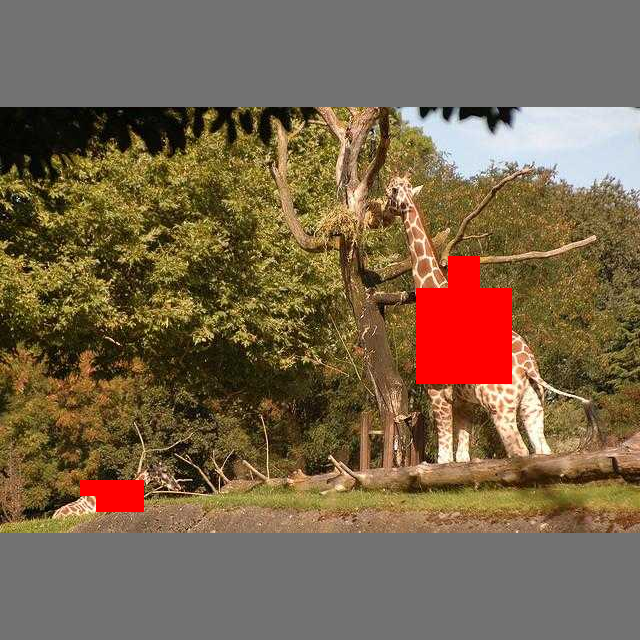

In [17]:
plot_mask_on_image(batch["img"][-1], merged)

In [18]:
import torch
import torch.nn.functional as F

def generate_mask_pyramid(mask80):
    # mask80: boolean tensor (80, 80)

    # Convert to float for interpolation
    m = mask80.float().unsqueeze(0).unsqueeze(0)   # (1,1,80,80)

    # Downscale to 40×40
    mask40 = F.interpolate(m, size=(40, 40), mode='nearest') \
                 .squeeze(0).squeeze(0).bool()

    # Downscale to 20×20
    mask20 = F.interpolate(m, size=(20, 20), mode='nearest') \
                 .squeeze(0).squeeze(0).bool()

    return mask80, mask40, mask20

In [19]:
mask80, mask40, mask20 = generate_mask_pyramid(merged)

In [20]:
print(mask80.shape, mask40.shape, mask20.shape, sep= "\n")

torch.Size([80, 80])
torch.Size([40, 40])
torch.Size([20, 20])


In [21]:
import torch
from PIL import Image

def masks_side_by_side(mask80, mask40, mask20):
    # Convert boolean → uint8 PIL images
    img80 = Image.fromarray((mask80.cpu().numpy().astype('uint8') * 255))
    img40 = Image.fromarray((mask40.cpu().numpy().astype('uint8') * 255))
    img20 = Image.fromarray((mask20.cpu().numpy().astype('uint8') * 255))

    # Resize masks to same height for visualization
    h = 80
    img80 = img80.resize((80, 80), Image.NEAREST)
    img40 = img40.resize((80, 80), Image.NEAREST)
    img20 = img20.resize((80, 80), Image.NEAREST)

    # Create a new canvas wide enough to stack 3 images horizontally
    combined = Image.new("L", (80 * 3, 80))

    # Paste images side-by-side
    combined.paste(img80, (0, 0))
    combined.paste(img40, (80, 0))
    combined.paste(img20, (160, 0))

    # Show result
    combined.show()

    return combined

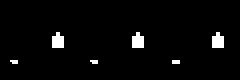

In [22]:
masks_side_by_side(mask80, mask40, mask20)

In [25]:
def plot_detailed_tensor(tensor):
    print("Detailed Boolean Tensor (20x20):")
    print("=" * 85)
    
    # Print column headers
    header = "     " + "".join(f"{j:2d}" for j in range(tensor.shape[1]))
    print(header)
    print("-" * 85)
    
    for i in range(tensor.shape[0]):
        # Visual representation
        visual_row = "".join("■ " if tensor[i, j] else "□ " for j in range(tensor.shape[1]))
        
        # Value representation
        value_row = " ".join("1" if tensor[i, j] else "0" for j in range(tensor.shape[1]))
        
        print(f"{i:2d} | {visual_row} |")
        print(f"    [ {value_row} ]")
        
        if i < tensor.shape[0] - 1:  # Don't print separator after last row
            print("    " + "-" * 41)

# Plot with detailed view
plot_detailed_tensor(mask80)

Detailed Boolean Tensor (20x20):
      0 1 2 3 4 5 6 7 8 910111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879
-------------------------------------------------------------------------------------
 0 | □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □  |
    [ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
    -----------------------------------------
 1 | □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □ □  |
    [ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0